In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
#read in the data and split into training and test sets
data = pd.read_csv('data/data_os_clean_imputed.csv', index_col='PUF_CASE_ID')
train = data[data['Year of Diagnosis'] <= 2014]
test = data[data['Year of Diagnosis'] > 2014]

X = train.drop(['3-yr Mortality'], axis=1)
y = train['3-yr Mortality']
X_test = test.drop(['3-yr Mortality'], axis=1)
y_test = test['3-yr Mortality']

In [3]:
#define the model and train it using the hyperparameters from the hyperparameter search
models = ['rf']
hp_dfs = {}
for model in models:
    hp_dfs[model] = pd.read_csv('hp_search/results_os/results_' + model + '.csv')

rf_params = {'bootstrap': hp_dfs['rf']['param_bootstrap'].iloc[0],
            'max_depth': hp_dfs['rf']['param_max_depth'].iloc[0],
            'max_features': hp_dfs['rf']['param_max_features'].iloc[0],
            'min_samples_leaf': hp_dfs['rf']['param_min_samples_leaf'].iloc[0],
            'min_samples_split': hp_dfs['rf']['param_min_samples_split'].iloc[0],
            'n_estimators': hp_dfs['rf']['param_n_estimators'].iloc[0]}
#change nan to None
rf_params = {k: None if pd.isna(v) else v for k, v in rf_params.items()}
best_rf = RandomForestClassifier(**rf_params)
best_rf.fit(X, y)

RandomForestClassifier(max_depth=20.0, min_samples_leaf=8, min_samples_split=6,
                       n_estimators=1500)

In [4]:
#get preds and area under the ROC curve score for the test set
rf_preds = best_rf.predict_proba(X_test)[:, 1]
test['pred_os'] = rf_preds
auroc = roc_auc_score(y_test, rf_preds)
print('RF AUROC: {:.3f}'.format(auroc))

RF AUROC: 0.749


/tmp/ipykernel_1581389/1401109112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_os'] = rf_preds


In [5]:
#read in the data with the survival times
data_km = pd.read_csv('data/data_km.csv', index_col='PUF_CASE_ID')
data_km.head()

,DX_LASTCONTACT_DEATH_MONTHS,PUF_VITAL_STATUS
PUF_CASE_ID,,
D66f458f9-bdc0-4c95-94a3-a5f8c5bb74f9,48.82,1.0
Dfc68ea23-71aa-4b0d-87c0-587b4ce13d04,65.64,0.0
D54a1d0da-4328-4ca5-8481-87cd73b33dd4,67.48,1.0
D62170955-5fc5-434e-8e6a-6a9e139851c4,37.19,1.0
D2cfdabba-8277-463e-bf64-7c3139b45372,15.47,1.0


In [6]:
#add the survival times to the test set
test['DX_LASTCONTACT_DEATH_MONTHS'] = np.NaN
test['PUF_VITAL_STATUS'] = np.NaN
test.update(data_km)
test.head()

/tmp/ipykernel_1581389/344693937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['DX_LASTCONTACT_DEATH_MONTHS'] = np.NaN
/tmp/ipykernel_1581389/344693937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PUF_VITAL_STATUS'] = np.NaN
/home/kchen/.local/lib/python3.8/site-packages/pandas/core/frame.py:7511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,Facility Type,Facility Location,Age,Sex,Race,Hispanic Ethnicity,Insurance Status,Urban/Rural,Distance from Hospital,Charlson-Deyo Score,...,M Stage,Pathologic Stage,Facility Volume Quartile,3-yr Mortality,Keratinizing,Basaloid,Cloacogenic,pred_os,DX_LASTCONTACT_DEATH_MONTHS,PUF_VITAL_STATUS
PUF_CASE_ID,,,,,,,,,,,,,,,,,,,,,
D66f458f9-bdc0-4c95-94a3-a5f8c5bb74f9,0,0,-0.707231,0,3,1,2,2,-0.678043,0,...,0,3,3.0,0,0,0,0,0.064678,48.82,1.0
D62170955-5fc5-434e-8e6a-6a9e139851c4,0,0,1.607898,0,3,1,1,2,-0.367283,0,...,0,3,3.0,0,0,0,0,0.151299,37.19,1.0
Dd3c2eac8-dbdf-464f-9066-a963c6752b09,2,2,0.284967,0,3,1,3,0,1.782135,0,...,0,3,4.0,0,0,0,0,0.076815,65.38,1.0
D57b642e3-2e44-4ef6-b4df-b91f6410c42e,0,1,-0.459182,1,1,1,3,2,-0.703939,0,...,0,3,2.0,1,0,0,0,0.137566,27.63,0.0
D7121b2ab-aab2-49ce-8449-dd1695d46b2e,0,2,-0.789914,1,1,1,3,2,-0.768681,0,...,0,3,3.0,0,0,0,0,0.191860,45.27,1.0


In [7]:
test['DX_LASTCONTACT_DEATH_MONTHS'].describe()

count    9347.000000
mean       41.981568
std        18.221405
min         0.000000
25%        33.330000
50%        44.750000
75%        55.360000
max        76.850000
Name: DX_LASTCONTACT_DEATH_MONTHS, dtype: float64

In [8]:
#narrow the dataset to include only what's needed for the curves
incl = ['pred_os', 'DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS']
data_km_pred = test[incl]
data_km_pred.shape

(9347, 3)

In [9]:
data_km_pred['pred_os'].describe()

count    9347.000000
mean        0.224053
std         0.136016
min         0.009507
25%         0.117496
50%         0.196189
75%         0.309477
max         0.785007
Name: pred_os, dtype: float64

In [10]:
#split the data into 3 groups based on the predicted survival times (tertiles of risk)
q_1 = round(data_km_pred['pred_os'].quantile(1 / 3), 4)
q_2 = round(data_km_pred['pred_os'].quantile(2 / 3), 4)
print(q_1, q_2)

0.1413 0.2669


In [11]:
data_km_pred['tertile'] = np.NaN
for i, row in data_km_pred.iterrows():
    if row['pred_os'] <= q_1:
        data_km_pred.loc[i, 'tertile'] = 1
    elif row['pred_os'] <= q_2:
        data_km_pred.loc[i, 'tertile'] = 2
    else:
        data_km_pred.loc[i, 'tertile'] = 3
data_km_pred['tertile'].value_counts(dropna=False)

/tmp/ipykernel_1581389/2371797294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_km_pred['tertile'] = np.NaN
/home/kchen/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/kchen/.local/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

3.0    3117
1.0    3116
2.0    3114
Name: tertile, dtype: int64

In [15]:
#get a list of time thresholds, 1-36 months
time_thresh = [i for i in range(0, 37, 1)]
#round the survival times to whole months
data_km_pred['months'] = round(data_km_pred['DX_LASTCONTACT_DEATH_MONTHS'], 0)

/tmp/ipykernel_1581389/3113987362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_km_pred['months'] = round(data_km_pred['DX_LASTCONTACT_DEATH_MONTHS'], 0)


In [16]:
data_1 = data_km_pred[data_km_pred['tertile'] == 1]
data_2 = data_km_pred[data_km_pred['tertile'] == 2]
data_3 = data_km_pred[data_km_pred['tertile'] == 3]

In [17]:
#make an empty dataframe to hold the results
km_1 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
#original number of patients
n_patients = data_1.shape[0]
#probability of survival
prob_survival = 1

#based on this explanation of kaplan-meier curves: https://towardsdatascience.com/kaplan-meier-curves-c5768e349479
for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data_1[(data_1['months'] == t) & (data_1['PUF_VITAL_STATUS'] == 1)].shape[0]
    #count the number of patients who died
    n_died = data_1[(data_1['months'] == t) & (data_1['PUF_VITAL_STATUS'] == 0)].shape[0]
    #calculate the percent of patients who died at time t, and subtract that from the probability of survival
    perc_died = n_died / n_patients
    prob_survival = prob_survival - perc_died
    km_1 = km_1.append({'time': t, 'n_patients': n_patients, 'n_died': n_died, 'prob_survival': prob_survival}, ignore_index=True)
    #update the number of patients by removing the number of patients who died
    n_patients = n_patients - n_died
km_1.head()

,time,n_patients,n_died,prob_survival
0,0.0,3116.0,0.0,1.000000
1,1.0,3116.0,3.0,0.999037
2,2.0,3113.0,9.0,0.996146
3,3.0,3104.0,11.0,0.992602
4,4.0,3093.0,7.0,0.990339


In [18]:
km_2 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
n_patients = data_2.shape[0]
prob_survival = 1
for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data_2[(data_2['months'] == t) & (data_2['PUF_VITAL_STATUS'] == 1)].shape[0]
    #count the number of patients who died
    n_died = data_2[(data_2['months'] == t) & (data_2['PUF_VITAL_STATUS'] == 0)].shape[0]
    #calculate the percent of patients who died at time t, and subtract that from the probability of survival
    perc_died = n_died / n_patients
    prob_survival = prob_survival - perc_died
    km_2 = km_2.append({'time': t, 'n_patients': n_patients, 'n_died': n_died, 'prob_survival': prob_survival}, ignore_index=True)
    #update the number of patients by removing the number of patients who died
    n_patients = n_patients - n_died
km_2.head()

,time,n_patients,n_died,prob_survival
0,0.0,3114.0,0.0,1.000000
1,1.0,3114.0,2.0,0.999358
2,2.0,3112.0,19.0,0.993252
3,3.0,3093.0,28.0,0.984200
4,4.0,3065.0,11.0,0.980611


In [19]:
km_3 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
n_patients = data_3.shape[0]
prob_survival = 1
for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data_3[(data_3['months'] == t) & (data_3['PUF_VITAL_STATUS'] == 1)].shape[0]
    #count the number of patients who died
    n_died = data_3[(data_3['months'] == t) & (data_3['PUF_VITAL_STATUS'] == 0)].shape[0]
    #calculate the percent of patients who died at time t, and subtract that from the probability of survival
    perc_died = n_died / n_patients
    prob_survival = prob_survival - perc_died
    km_3 = km_3.append({'time': t, 'n_patients': n_patients, 'n_died': n_died, 'prob_survival': prob_survival}, ignore_index=True)
    #update the number of patients by removing the number of patients who died
    n_patients = n_patients - n_died
km_3.head()

,time,n_patients,n_died,prob_survival
0,0.0,3117.0,1.0,0.999679
1,1.0,3116.0,20.0,0.993261
2,2.0,3096.0,64.0,0.972589
3,3.0,3032.0,86.0,0.944225
4,4.0,2946.0,68.0,0.921143


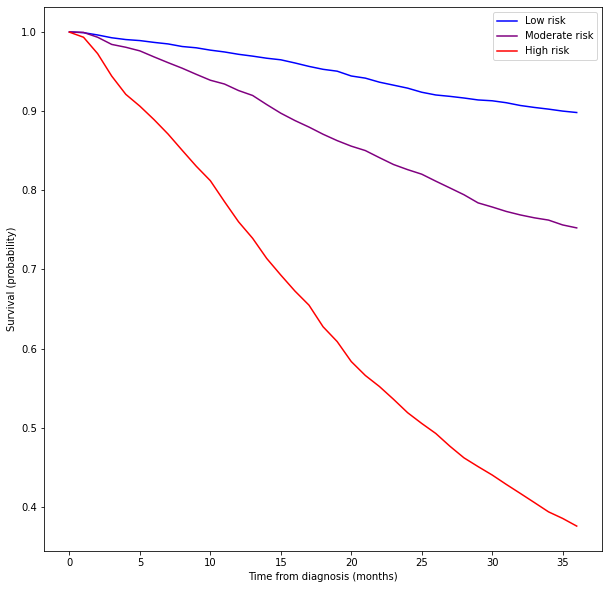

In [20]:
#plot the survival curves for the three tertiles on the same plot
# plt.plot(km_df['time'], km_df['prob_survival'], label='All Patients')
plt.figure(figsize=(10,10))
plt.plot(km_1['time'], km_1['prob_survival'], label='Low risk', color='blue')
plt.plot(km_2['time'], km_2['prob_survival'], label='Moderate risk', color='purple')
plt.plot(km_3['time'], km_3['prob_survival'], label='High risk', color='red')
plt.xlabel('Time from diagnosis (months)')
plt.ylabel('Survival (probability)')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.savefig('results/os/km.png', dpi=300, bbox_inches='tight')

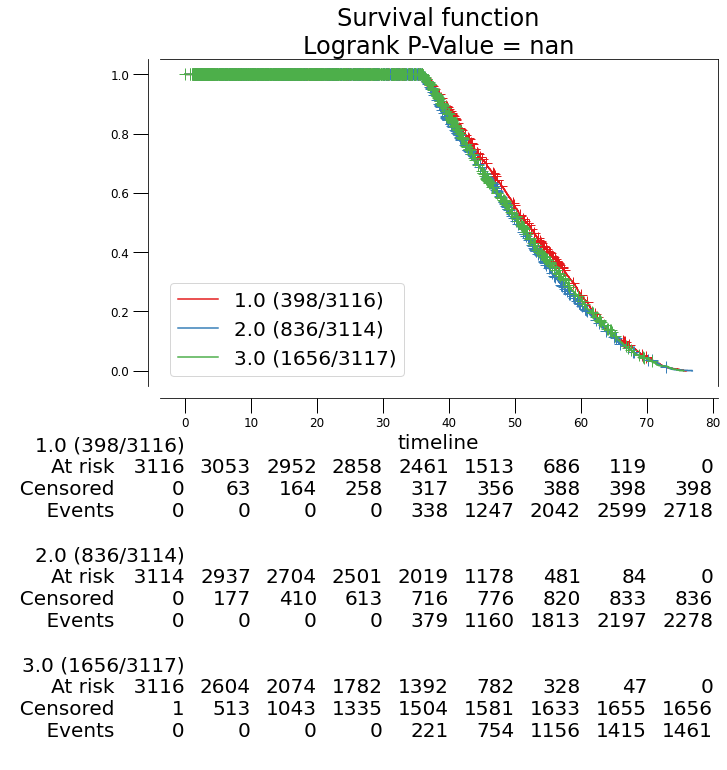

In [21]:
#did it again using a package but it looks a lot different
import kaplanmeier as km
time_event = data_km_pred['DX_LASTCONTACT_DEATH_MONTHS']
censoring = data_km_pred['PUF_VITAL_STATUS']
y = data_km_pred['tertile']

results = km.fit(time_event, censoring, y)
km.plot(results)